# Nearest nodes extraction and google street image downloading

---

## Technical information
- Research: Urban Safe Feminist design
- Author: Sergio Paredes
- Creation date: 2024-06-03

## Objectives
1.   Implement a method that allows to download the closest (secondary) nodes from a main node.
2.   Capture and download images of the main and secondary nodes using the google street view api


## Summary
This notebook was developed for the generation
of a method to capture the closest coordinates (nodes) with respect to a main node, and then with respect to a main node, and after that, capture images of the main and secondary nodes. of the main and secondary nodes.

For this, the OSMNX library was used.

## Results
- In result 1, from the 62 main nodes, 8860 secondary nodes were obtained; considering the distance of 350 meters.
- In result two, approximately 35000 images were obtained from the main and secondary nodes.

## Change log:
- 2024-06-03 Initial notebook creation

### Libraries

In [3]:
# OSMNX library installation in local environment
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 394.5 kB/s eta 0:00:00


In [4]:
import os
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# Google libraries to make the connection with the drive
from google.colab import files
from google.colab import drive

### Google drive connection

In [5]:
drive.mount("/content/drive") # Request for connection to google drive account is made.

Mounted at /content/drive


In [6]:
path = r"/content/drive/MyDrive/Diversa/Urbansafe"
pathOrigen = path+"/urbansafe.csv"
pathFinal = path+"/nodos_expandidos.csv"

### Function Secondary nodes

In [27]:
def expandir_coordenadas(coordenadas, distancia=350):
    coordenadas_expandidas = []

    # An empty DataFrame is created to store the expanded coordinates.
    df_expandido = pd.DataFrame(columns=['latitude', 'longitude', 'node_type', 'id'])

    for coord in coordenadas:
        # Get the id, latitude and longitude of the current coordinate (this will do math with the original source to bring the other fields).
        id_coordenada = coord['id']
        latitud = coord['latitude']
        longitud = coord['longitude']

        G = ox.graph_from_point((latitud, longitud), dist=distancia, network_type='all')

        # Obtain the coordinates of nearby nodes.
        coordenadas_nodos = [(G.nodes[nodo]['y'], G.nodes[nodo]['x']) for nodo in G.nodes()]

        coordenadas_expandidas.extend(coordenadas_nodos)

        # A temporary DataFrame is created for the expanded coordinates of this iteration.
        df_temporal = pd.DataFrame(coordenadas_nodos, columns=['latitude', 'longitude'])

        # Assign the corresponding id to all the rows of the temporary DataFrame
        df_temporal['node_type'] = 'secundaria'
        df_temporal['id'] = id_coordenada

        df_expandido = pd.concat([df_expandido, df_temporal])

    return df_expandido

### Outputs primary and secondary nodes

In [28]:
df = pd.read_csv(pathOrigen, sep='|')


inputCoord = []

for _, row in df.iterrows():
    misFilas = {
        'id': row['index'],
        'latitude': row['latitude'],
        'longitude': row['longitude']
    }

    inputCoord.append(misFilas)


# Convert the list to a new DataFrame
df_input = pd.DataFrame(inputCoord)
valor = 'principal'

df_input.insert(0, 'node_type', valor)

# On this line I call the function
coordenadas_expandidas = expandir_coordenadas(inputCoord)

# The original df is joined to extract additional variables.
df_outPut = pd.DataFrame(coordenadas_expandidas)
df_outPut = df_outPut.loc[:, ['node_type','id', 'latitude', 'longitude']]
df_res = pd.concat([df_input, df_outPut], ignore_index=True)
df_res = df_res.drop_duplicates()

columnas = ['index','id', 'country', 'country_code', 'city'] # Select the variables to be displayed in the final output
df_orig = df[columnas]
df_final = df_orig.merge(df_res, left_on='index', right_on='id', how='inner')
df_final = df_final.drop(columns=['id_y']).rename(columns={'id_x': 'id'})

# Save the resulting DataFrame in a CSV file in the shared folder in google drive
df_final.to_csv(pathFinal, sep='|', index=False)

### Image capture method

In [23]:
class StreetView:
    def __init__(self, latitude: float, longitude: float, fov: int = 90, api_key: str = ''):
        """ Initialize StreetView class.

        Args:
            latitude (float): Streetview latitude.
            longitude (float): Streetview longitude.
            fov (int): Field of view (horizontal) in degrees, max 120.
            api_key (str): Google API key.
        """
        self.latitude = latitude
        self.longitude = longitude
        assert 0 < fov <= 120, "FOV must be between 1 and 120"
        self.fov = fov
        self.api_key = api_key
        self._meta_url = None
        self._metadata = None

    @property
    def meta_url(self):
        """Construct meta URL for retrieving Street View metadata."""
        if not self._meta_url:
            self._meta_url = f"https://maps.googleapis.com/maps/api/streetview/metadata?location={self.latitude},{self.longitude}&key={self.api_key}"
        return self._meta_url

    @property
    def metadata(self):
        """Retrieve and cache metadata for the Street View panorama."""
        if not self._metadata:
            resp = requests.get(self.meta_url)
            self._metadata = json.loads(resp.content)
        return self._metadata

    @property
    def pano_id(self):
        """Extract panorama ID from metadata."""
        return self.metadata.get('pano_id', '')

    def download_images(self, output_path_pattern: str, id: str):
        """Downloads multiple images for different heading angles.

        Args:
            output_path_pattern (str): Path pattern to save the downloaded images, including a placeholder for the heading angle.
        """
        headings = [0, 90, 180, 270]  # Define different heading angles
        for heading in headings:
            # Construct URL for each heading
            url = f"https://maps.googleapis.com/maps/api/streetview?size=448x448&location={self.latitude},{self.longitude}&pano={self.pano_id}&heading={heading}&fov={self.fov}&key={self.api_key}"

            # Perform the request and save the image
            resp = requests.get(url)
            if resp.status_code == 200:
                img = Image.open(BytesIO(resp.content))
                output_path = output_path_pattern.format(id, heading)
                img.save(output_path)
                print(f"Image saved to {output_path}")
            else:
                print(f"Failed to download image for heading {heading}")

### Image generation

In [27]:
if __name__ == "__main__":
    api_key = 'yourAPIkeyhere'
    df = pd.read_csv(pathFinal, sep='|')

    for id, row in df.iterrows():
        sv = StreetView(row['latitude'], row['longitude'], fov=120, api_key=api_key)
        sv.download_images(path+"/streetview_{}_{}.png", id)

Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_0_0.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_0_90.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_0_180.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_0_270.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_1_0.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_1_90.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_1_180.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_1_270.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_2_0.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_2_90.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_2_180.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_2_270.png
Image saved to /content/drive/MyDrive/Diversa/Urbansafe/streetview_3_0.png
Image save

### Exploratory data analysis

In [20]:
# 1. Overview
print("First rows of the DataFrame:")
print(df_final.head())

First rows of the DataFrame:
  index         id    country country_code     city   node_type   latitude  \
0     1  ARGS20031  Argentina          ARG  Rosario   principal -32.961405   
1     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.961432   
2     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.961410   
3     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.961568   
4     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.961294   

   longitude  
0 -60.684841  
1 -60.684719  
2 -60.684833  
3 -60.684010  
4 -60.685488  


     Country  Count
0   Colombia   2217
1    Ecuador   1857
2    Vietnam   1316
3  Tailandia   1205
4  Argentina    866
5       Peru    594
6    Myanmar    527
7     Brazil    340


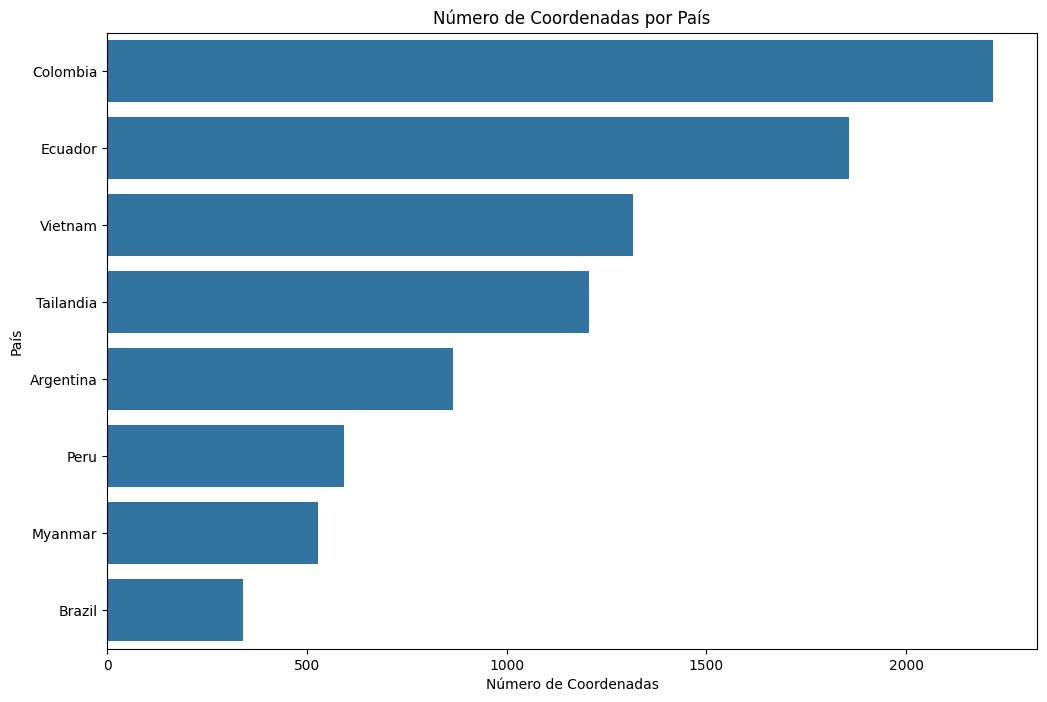

In [ ]:
# 2. Count coordinates by country
df_coordenadas_por_pais = df_final['country'].value_counts().reset_index()
df_coordenadas_por_pais.columns = ['Country', 'Count']

# show the DataFrame
print(df_coordenadas_por_pais)

# Display of coordinates by country
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Country', data=df_coordenadas_por_pais)
plt.title('Number of Coordinates by Country')
plt.xlabel('Number of Coordinates')
plt.ylabel('Country')
plt.show()

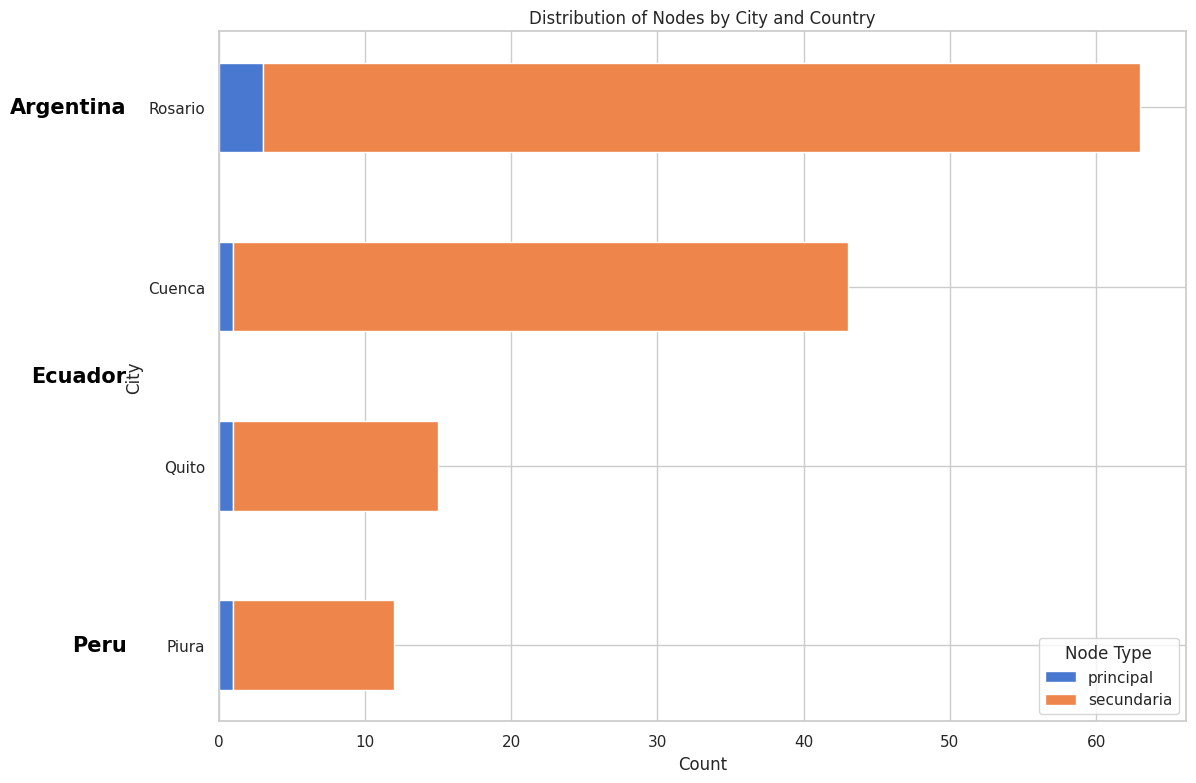

In [40]:
# 3. Distribution of Nodes by City and Country

# grouping of nodes by country and city
grouped = df_final.groupby(['country', 'city', 'node_type']).size().reset_index(name='count')

# Create the pivoted DataFrame for the stacked chart
pivot_table = grouped.pivot_table(index=['country', 'city'], columns='node_type', values='count', fill_value=0).reset_index()

# Create a new column combining country and city
pivot_table['country_city'] = pivot_table['city'] + '       (' + pivot_table['country'] + ')'

# Chart configuration
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for the different types of nodes
colors = sns.color_palette("muted", n_colors=2)

# Create horizontal stacked bars
bottom = [0] * len(pivot_table)
bar_width = 0.5  # Reduces the width of the bars

for node_type, color in zip(['principal', 'secundaria'], colors):
    values = pivot_table[node_type].values
    ax.barh(pivot_table['city'], values, left=bottom, height=bar_width, color=color, label=node_type)
    bottom = [i+j for i, j in zip(bottom, values)]

# Add tags and caption
ax.set_xlabel('Count')
ax.set_ylabel('City')
ax.set_title('Distribution of Nodes by City and Country')
ax.legend(title='Node Type')
ax.invert_yaxis()  # Invert the Y axis so that the stacked bars are aligned correctly.

# Add country labels to the left margin
unique_countries = pivot_table['country'].unique()
current_country = ''
y_pos = 0

for country in unique_countries:
    cities = pivot_table[pivot_table['country'] == country]['city']
    mid_point = (cities.index[-1] + cities.index[0]) / 2
    ax.text(-max(bottom) * 0.1, mid_point, country, ha='right', va='center', fontsize=15, fontweight='bold', rotation=0, color='black')

# Adjust the margins so that the text does not get mounted
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

plt.tight_layout()
plt.show()